# Logestic Regression Modeling with Cross Validation on Word Frequecy

## Part 1: load dependencies and read data

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import unittest
import matplotlib.pyplot as plt
import re

In [2]:
review = pd.read_csv("data/reviews.csv")

## Part 2: _Term Frequency - Inverse Document Frequenc (TF-IDF)_ Transformation

TF-IDF means "Term Frequency - Inverse Document Frequency". It is a powerful technique to detect important words in a collection of documents. "Term Frequency" (TF) meansures the frequency of word $w_i$ in document $d_j$, and the "Inverse Document Frequency" (IDF) measures how much information the word provides, i.e., the frequency of word $w_i$ in the collection of documents. The TF-IDF value for a word $w_i$ in document $d_j$ is positively associated with word frequencies and negatively associated with document frequencies. The math formula for TF-IDF is:

$$TF-IDF(w_i, d_j) = TF(w_i, d_j) \times IDF(w_i)$$

And IDF can be smoothed using the formula:

$$IDF_{smooth}(w_i) = log(\frac{N}{1 + n_i})$$

where $N$ is the number of documents considered and $n_i$ is the frequency of $w_i$ in the all documents considered.

In this project, TF-IDF is used in logistic regression classification. In the following analysis, we did several steps to fit the best logistic regression model:

1. constructed the TF-IDF matrix, 
2. used $\chi^2$ independent test to select top $1,000$ keywords from training set,
3. computed the TF-IDF values of the $1,000$ keywords,
4. splited the whole dataset into training set and validation set using 10-fold cross-valudation,
5. used the _TF-IDF values_ as covariates, the _star values_ of review as responses, to build a logistic regression model in the training set,
6. tries 3 different tuning parameters respectively,
7. applied the models built in training set to validation set and obtained the predicted _star values_ for each tuning parameter,
8. computed the Mean Squared Error (MSE) between true _star value_ and predicted _star value_ in validation set, 
9. and chose the optimal tuning parameters which produces lowest MSE.

### construct the TF-IDF matrix

In [3]:
# make raw dataset into the format for TF-idf transformation
star = np.array(review.stars)
text = list(map(lambda x: x[2:-1].replace("\\n","\n"), review.text))
pat = re.compile(r"[^\w\s]")
text_clean = np.array(list(map(lambda x: pat.sub(" ",x).lower(), text)))

# create TF-IDF
vectorizer = TfidfVectorizer(stop_words = "english")
text_features = vectorizer.fit_transform(text_clean)
vocab = vectorizer.get_feature_names()

In [4]:
print("Number of observations in the text_features dataset is", text_features.shape[0],
      "\nNumber of covariates in the text_features dataset is", text_features.shape[1])

Number of observations in the text_features dataset is 60222 
Number of covariates in the text_features dataset is 50137


## Part 3: Compute MSE
### Write a function to compute step 2 to 8

In [5]:
def compute_CV_mse(df_text, df_star, n_fold, n_words, seed, parameters):
    """Return the Mean Squared Error (MSE) between predictied reponses and true responses in validation set.
    
    Parameters
    ----------
    
    df_text: TF-IDF format sparse matrix
    df_star: array of responses in logistic model
    n_fold: number of folds in cross-validation, positive integer
    n_words: number of keywords selected, positive integer
    seed: random seed for splitting training and validation set
    parameters: tuning parameters of logistic regression, positive float vector
    
    Return
    ------
    Array
        A numeric Array where each value in dimension 0 is the tuning parameter, 
        and each value in dimension 1 is MSE computed using the corresponding tuning parameter
        
    Example
    -------
    
    >>> text_features = vectorizer.fit_transform(text_clean)
    ... star = np.array(review.stars)
    ... compute_CV_mse(text_features, star, 2, 10, 1, (100.0, 1000.0))
    """
    # parameters must be positive
    test = False
    if isinstance(n_fold, int):
        test = True
    else:
        raise TypeError("n_fold is not an integer")
    if n_fold > 0:
        test = True
    else:
        raise ValueError("n_fold should be positive")
    if isinstance(n_words, int):
        test = True
    else:
        raise TypeError("n_words is not an integer")
    if n_words > 0:
        test = True
    else:
        raise ValueError("n_words should be positive")  
    for i in parameters:
        if i > 0:
            test = True
        else:
            raise ValueError("parameters should be positive")
    # create K-folds
    kf = KFold(n_fold, shuffle = True, random_state = seed)
    # create empty dataframe
    mse = np.zeros([n_fold + 1, len(parameters)])
    k = 0
    for train_idx,val_idx in kf.split(df_text):
        # create training and validation sets
        text_features_train = df_text[train_idx]
        text_features_val = df_text[val_idx]
        star_train = df_star[train_idx]
        star_val = df_star[val_idx]
        # using $chi^2$ independent test to select top  1,0001,000  keywords from training set
        fselect = SelectKBest(chi2, k = n_words)
        # transform training set to format that fits fselect functuon
        text_features_train = fselect.fit_transform(text_features_train, star_train)
        text_features_val = text_features_val[:, fselect.get_support()]
        # compute MSE for each parameter
        t = 0
        for para in parameters:
            # logistic regression with C = parameter,
            # where C is positive float, indicates "Inverse of regularization strength", 
            # and smaller values specify stronger regularization.
            mod_temp = LogisticRegression(C = para)
            # fit regression on training set
            mod_temp.fit(X = text_features_train, y = star_train)
            # predict star values on validation set
            pred = mod_temp.predict(X = text_features_val)
            # compute MSE as a dataframe, each value is one mse in one validation set
            mse[k,t] = sum((pred - star_val)**2)/len(pred)
            t+= 1
        k+= 1
        # compute overall MSE
        mse_out = np.mean(mse[1:n_fold,], axis = 0)       
    return(np.vstack((parameters, mse_out)))

**compute MSE with 10 fold cross-validation, of first 1,000 keywords, with randome splitting seed = 1, and tuning parameters = (100, 1000, 10000, 100000).**

**NOTE: Original tuning parameter range is [1, 100,000], the current range [10, 100] is selected after many trails as the optimal range of tuning parameters**

In [43]:
# output
para, mse = compute_CV_mse(df_text = text_features, df_star = star, n_fold = 10, 
               n_words = 1000, seed = 1, parameters = list(range(10, 110, 10)))

In [62]:
d = {'parameters' : pd.Series(para),
     'mse' : pd.Series(mse)}
df = pd.DataFrame(d)
df_sorted = df.sort_values(by=['mse'])
print("Sorted MSE and corresponding parameters: small to big")
df_sorted

Sorted MSE and corresponding parameters: small to big


,mse,parameters
4,0.748335,50.0
3,0.749202,40.0
1,0.749553,20.0
2,0.749811,30.0
5,0.749885,60.0
6,0.750014,70.0
7,0.751435,80.0
8,0.753058,90.0
0,0.753077,10.0
9,0.753630,100.0


Choose tuning parameters with minimum mse, and we get:

In [54]:
print("The minimum MSE is", np.round(df_sorted.iloc[0][0], 4), "with tuning parameter =", df_sorted.iloc[0][1])

The minimum MSE is 0.7483 with tuning parameter = 50.0


**Plot MSE for different tuning parameters**

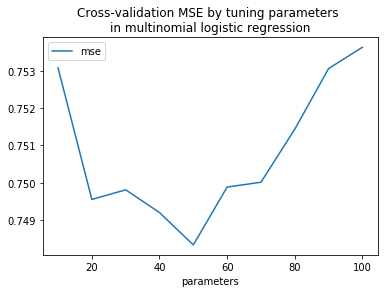

In [66]:
df.plot(x = 'parameters', y = "mse")
plt.title("Cross-validation MSE by tuning parameters \nin multinomial logistic regression")
plt.savefig("fig/mse_logistic.png")
plt.show()

## Part 4: Unit Test

In [56]:
def test_n_words_positive():
    """Test that when n_words is negative, raise value error"""
    # YOUR CODE HERE
    try:
        compute_CV_mse(df_text = text_features, df_star = star, n_fold = 2, 
               n_words = -1, seed = 1, parameters = 10.0**np.arange(0,2))
    except ValueError:
        assert True
    else:
        assert False
def test_n_words_integer():
    """Test that when n_words is negative, raise value error"""
    # YOUR CODE HERE
    try:
        compute_CV_mse(df_text = text_features, df_star = star, n_fold = 2, 
               n_words = "f", seed = 1, parameters = 10.0**np.arange(0,2))
    except TypeError:
        assert True
    else:
        assert False
def test_n_folds_positive():
    """Test that when n_words is negative, raise value error"""
    # YOUR CODE HERE
    try:
        compute_CV_mse(df_text = text_features, df_star = star, n_fold = -2, 
               n_words = 1, seed = 1, parameters = 10.0**np.arange(0,2))
    except ValueError:
        assert True
    else:
        assert False
def test_n_folds_integer():
    """Test that when n_words is negative, raise value error"""
    # YOUR CODE HERE
    try:
        compute_CV_mse(df_text = text_features, df_star = star, n_fold = "f", 
               n_words = 2, seed = 1, parameters = 10.0**np.arange(0,2))
    except TypeError:
        assert True
    else:
        assert False
def test_parameters_positive():
    """Test that when n_words is negative, raise value error"""
    # YOUR CODE HERE
    try:
        compute_CV_mse(df_text = text_features, df_star = star, n_fold = 2, 
               n_words = 1, seed = 1, parameters = (-1,-3))
    except ValueError:
        assert True
    else:
        assert False

In [57]:
test_n_words_positive()
test_n_words_integer()
test_n_folds_positive()
test_n_folds_integer()